The dataset was created by the University of Oxford, in collaboration with 10 medical centers in the US and Intel Corporation who developed the telemonitoring device to record the speech signals. The original study used a range of linear and nonlinear regression methods to predict the clinician's Parkinson's disease symptom score on the UPDRS scale.


Data Set Information:

This dataset is composed of a range of biomedical voice measurements from 42 people with early-stage Parkinson's disease recruited to a six-month trial of a telemonitoring device for remote symptom progression monitoring. The recordings were automatically captured in the patient's homes. 

Columns in the table contain subject number, subject age, subject gender, time interval from baseline recruitment date, motor UPDRS, total UPDRS, and 16 biomedical voice measures. Each row corresponds to one of 5,875 voice recording from these individuals. The main aim of the data is to predict the motor and total UPDRS scores ('motor_UPDRS' and 'total_UPDRS') from the 16 voice measures. 


In [31]:
import numpy as np 
import pandas
import matplotlib.pyplot as plt 
import os
import seaborn as sns

We will now explore the data and see which variable can be our independent variable 

In [32]:
os.listdir()
df = pandas.read_csv("Parkinsons.csv")
Y_motor =np.asarray(df["motor_UPDRS"])
Y_total =np.asarray(df["total_UPDRS"])
y=np.log(df["Jitter(%)"])
df.head()

,subject#,age,sex,test_time,motor_UPDRS,total_UPDRS,Jitter(%),Jitter(Abs),Jitter:RAP,Jitter:PPQ5,...,Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,Shimmer:APQ11,Shimmer:DDA,NHR,HNR,RPDE,DFA,PPE
0,1,72,0,5.6431,28.199,34.398,0.00662,0.000034,0.00401,0.00317,...,0.230,0.01438,0.01309,0.01662,0.04314,0.014290,21.640,0.41888,0.54842,0.16006
1,1,72,0,12.6660,28.447,34.894,0.00300,0.000017,0.00132,0.00150,...,0.179,0.00994,0.01072,0.01689,0.02982,0.011112,27.183,0.43493,0.56477,0.10810
2,1,72,0,19.6810,28.695,35.389,0.00481,0.000025,0.00205,0.00208,...,0.181,0.00734,0.00844,0.01458,0.02202,0.020220,23.047,0.46222,0.54405,0.21014
3,1,72,0,25.6470,28.905,35.810,0.00528,0.000027,0.00191,0.00264,...,0.327,0.01106,0.01265,0.01963,0.03317,0.027837,24.445,0.48730,0.57794,0.33277
4,1,72,0,33.6420,29.187,36.375,0.00335,0.000020,0.00093,0.00130,...,0.176,0.00679,0.00929,0.01819,0.02036,0.011625,26.126,0.47188,0.56122,0.19361


In [33]:
df=df.drop(df.columns[0:7],1)
col_names=df.columns
X=np.asarray(df)

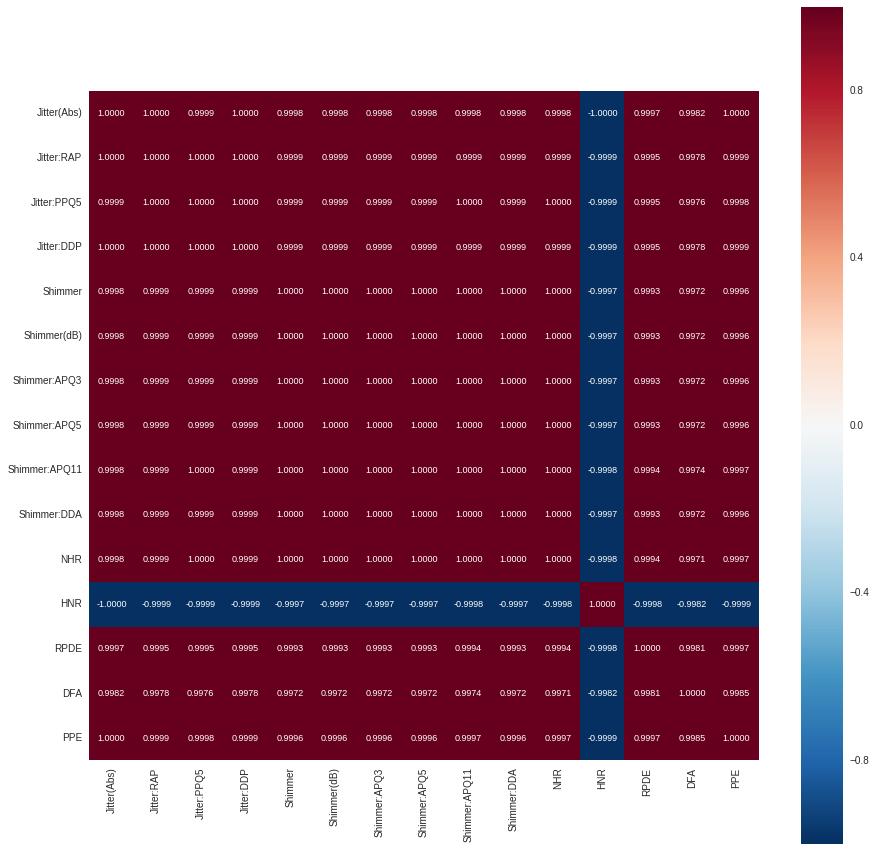

In [34]:
cov_matrix = np.cov(X.T)
fig, ax = plt.subplots(figsize=(15,15))
corr_coeff_mat = np.corrcoef(cov_matrix)
sns.heatmap(corr_coeff_mat,vmax=0.8,cbar=True, annot=True, square=True, fmt='.4f',
	annot_kws={'size':9},ax=ax,yticklabels=col_names, xticklabels=col_names)
plt.show()

WE will now do a 1-D linear regression between two variables and plot the data points 

In [35]:
def fit_line_1d(x,y):
    A=x.dot(x)
    B=np.sum(x)
    C=x.dot(y)
    N=x.shape[0]
    D =np.sum(y)
    w1=np.linalg.solve(np.array([[A,B],[B,N]]),np.array([C,D]))
    return w1
def get_r2(y_pred,y):
    numerator=np.square(y-y_pred).sum()
    denominator=np.square(y-y.mean()).sum()
    r2=1-(numerator/denominator)
    return r2

In [36]:
r2=[]
for item in col_names:
    x=np.log(df[item])
    weights_1d = fit_line_1d(x,y)
    y_pred = weights_1d[0]*x + weights_1d[1]
    
    r2.append(get_r2(y_pred,y))
print("The list of all r2 values for independent variables wrt Jitter(%) is ") 
r2

The list of all r2 values for independent variables wrt Jitter(%) is 


[0.83676022041513787,
 0.93734670451930513,
 0.93954574438355032,
 0.93735329555889924,
 0.49156460816938818,
 0.51599005459007552,
 0.43954683305813214,
 0.45197866423387201,
 0.45226254049769454,
 0.43954812242728891,
 0.69581496566890233,
 0.57136599558543355,
 0.30871954650416045,
 0.16118965955759068,
 0.69657727741523234]

Picking the column with the best r2 with our dependent variable and plotting it 

In [37]:
r2=np.asarray(r2)
idx=np.argmax(r2)

string_id=col_names[idx]

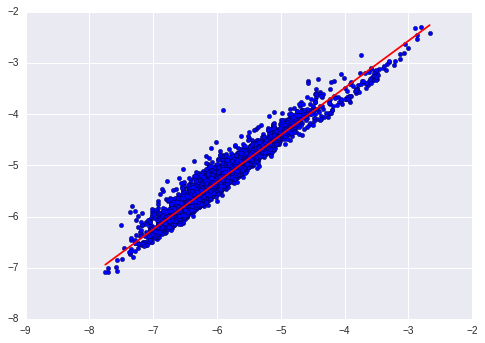

In [38]:
x=np.log(df[string_id])
plt.scatter(x,y)
weights_1d = fit_line_1d(x,y)
y_pred = weights_1d[0]*x + weights_1d[1]
plt.plot(sorted(x),sorted(y_pred),color="red")
plt.show()

WE will now use gradient descent optimization and predict the Y values  using all dimentions with l1 regularization.For this we will first split the data into training set and test set,with a 70:30 ratio.
Using the trained weights we will compare the actual Y values of the test set with the Y values We predicted out of the model. 

In [105]:
df1 = pandas.read_csv("Parkinsons.csv")
X_train=np.asarray(df1.ix[:4099,"Jitter(%)":])
X_test=np.asarray(df1.ix[4100:,"Jitter(%)":])
Y_total_train = Y_total[:4100,]
Y_total_test =Y_total[4100:]

N=X_train.shape[0]
D=X_train.shape[1]
Bias = np.ones(N).reshape(N,1)
X_train = np.hstack((X_train , Bias))
D=X_train.shape[1]

In [106]:


w =np.random.randn(D)/np.sqrt(D)#Initializing random weights as our start point for gradient descent
l1_reg=10
LR=0.0000004999
l2_reg = 500
cost=[]
D

17

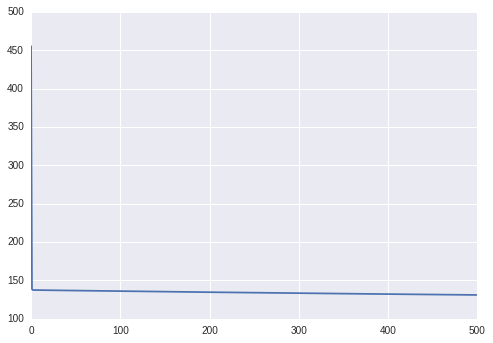

The r2 for the training set is 


-0.26023594548113005

In [107]:
for i in range(0,500):
        yhat = X_train.dot(w)
        residue=(yhat-Y_total_train)
        w=w-LR*(X_train.T.dot(residue)+l1_reg*np.sign(w)+l2_reg*w)
        #w=w-LR*(X_train.T.dot(residue)+l2_reg*w)
        cost.append((residue.dot(residue))/N)
        
plt.plot(cost)
plt.show()
        
    
    
    
    
    

r2=get_r2(yhat,Y_total_train)
print("The r2 for the training set is ")
r2


In [108]:
Bias_test = np.ones(1775).reshape(1775,1)
X_test = np.hstack((X_test , Bias_test))


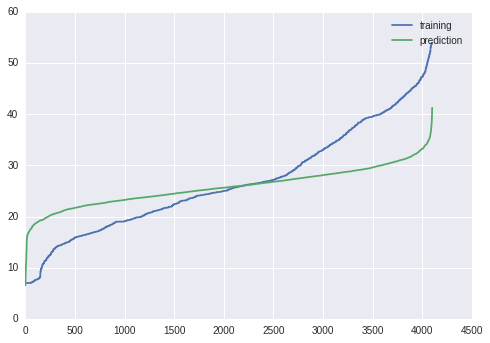

In [109]:
x_in = np.linspace(0,N,N)
plt.plot(sorted(x_in),sorted(Y_total_train),label="training")
plt.plot(sorted(x_in),sorted(yhat),label="prediction")

plt.legend()
plt.show()


Working on test data Now !!!

In [110]:
Y_prediction = X_test.dot(w)
r2=get_r2(Y_prediction,Y_total_test)
print("The r2 for the test set is:-")
r2

The r2 for the test set is:-


-1.3808460442308563

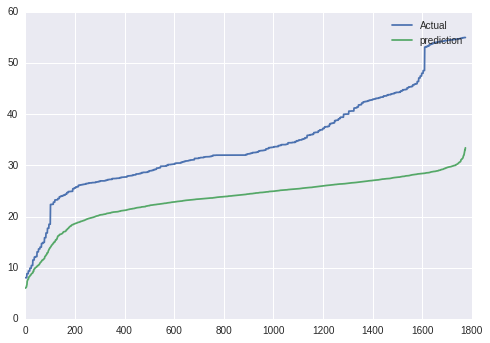

In [111]:
#x_in = np.linspace(0,N,1775)
plt.plot(sorted(Y_total_test),label="Actual")
plt.plot(sorted(Y_prediction),label="prediction")

plt.legend()
plt.show()
